In [50]:
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt

# 1. Læs data
df = pd.read_csv("data/overview.csv")
movies_df = pd.read_csv("data/movies.csv")

# 2. Rens cast-kolonne
df["cast_names"] = df["cast_names"].fillna("").astype(str)

# 3. Lav cast_list
df["cast_list"] = df["cast_names"].apply(
    lambda s: [c.strip() for c in s.split("|") if c.strip() != ""]
)

# 4. Join overview med movies
merged_df = df.merge(movies_df[["movieId", "genres"]], on="movieId", how="left")

# 5. Split genres til liste
merged_df["genres"] = merged_df["genres"].fillna("")
merged_df["genre_list"] = merged_df["genres"].apply(
    lambda s: [g.strip() for g in s.split("|") if g.strip() != ""]
)

# 6. Filtrér på en bestemt genre (præcist match)
target_genre = "Action"   # ← Skift her


genre_df = merged_df[ merged_df["genre_list"].apply(lambda lst: target_genre in lst) ].copy()

# 7. Tjek resultat
#print(genre_df.head())
# antal film før filtrering
print("Antal film i alt:", len(merged_df))
print("Antal film i genren:", len(genre_df))
# vis genre kolonenn
#print(merged_df[ "genre_list"].head())

Antal film i alt: 86411
Antal film i genren: 9553


In [40]:
# 4. Opret graf
G = nx.Graph()

for cast in df["cast_list"]:
    # Tilføj noder (skuespillere)
    for actor in cast:
        if actor not in G:
            G.add_node(actor)
    
    # Tilføj kanter for alle par af skuespillere i samme film
    for a, b in itertools.combinations(cast, 2):
        if G.has_edge(a, b):
            # øg vægten hvis kanten allerede findes
            G[a][b]["weight"] += 1
        else:
            G.add_edge(a, b, weight=1)

# 5. Evt. filtrer netværket (f.eks. kun skuespillere med mindst X forbindelser)
# Her laver vi fx et subgraf med skuespillere, der har mindst 3 naboer
min_degree = 700
nodes_to_keep = [n for n, d in G.degree() if d >= min_degree]
H = G.subgraph(nodes_to_keep).copy()

# print nogle informationer om grafen
print("Original graf: {} noder, {} kanter".format(G.number_of_nodes(), G.number_of_edges()))
print("Subgraf med mindst {} forbindelser: {} noder, {} kanter".format(min_degree, H.number_of_nodes(), H.number_of_edges()))

Original graf: 250995 noder, 2886264 kanter
Subgraf med mindst 700 forbindelser: 47 noder, 309 kanter


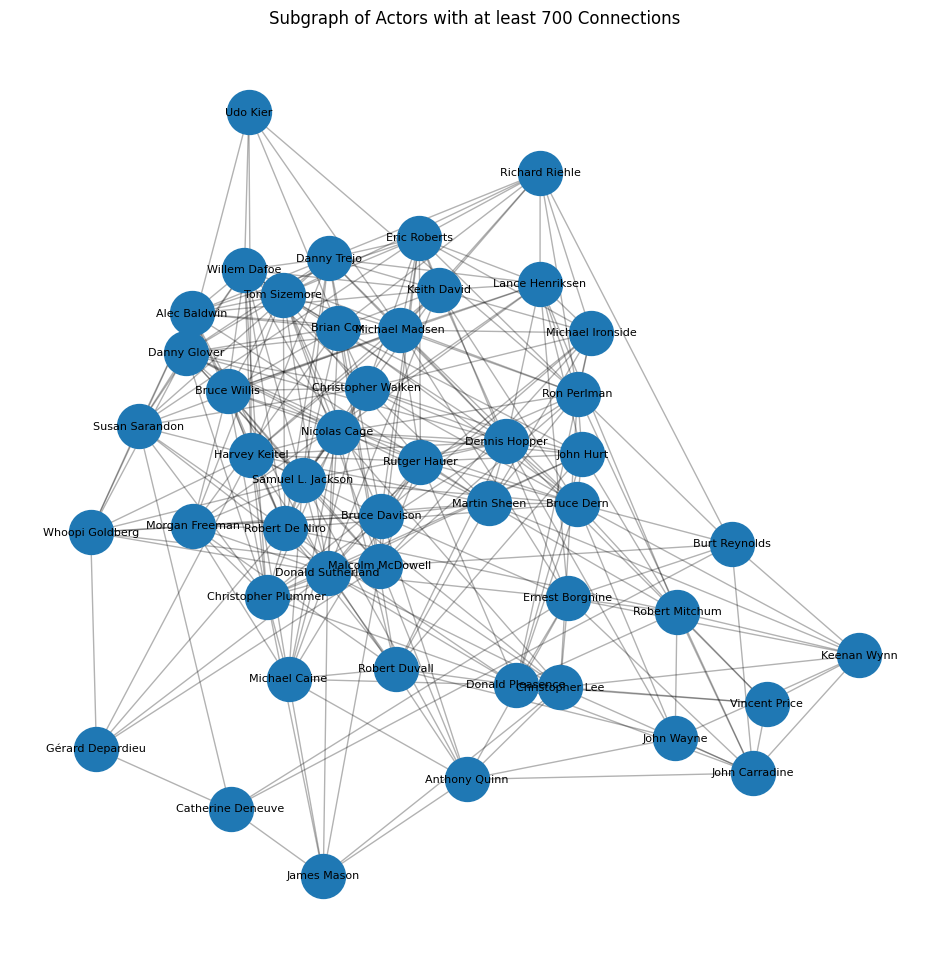

In [44]:
# lav et plot af grafen
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(H, k=0.1)  # positions for all nodes
nx.draw_networkx_nodes(H, pos, node_size=1000)
nx.draw_networkx_edges(H, pos, alpha=0.3)
nx.draw_networkx_labels(H, pos, font_size=8)
plt.title("Subgraph of Actors with at least {} Connections".format(min_degree))
plt.axis("off")
plt.show()
